In [1]:

import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.preprocessing import PowerTransformer

import sys, os
import random 

import community as community_louvain
import matplotlib.cm as cm
import networkx as nx, networkx

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython.display import display
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [2]:
data = pd.read_pickle('3mI_Clique_01.pkl')
data.shape

(17123791, 12)

In [3]:
data.head()

,InstrumentID,NTranSeaBs,QTitTran,PTran,buyer_trader,buyer,Buy_PLimSaiOm,seller_trader,seller,sell_PLimSaiOm,datetime,Price
13,IRO3BDYZ0001,2156,600,3530.0,569,906667,3560.0,256,493489,3530.0,2019-10-16 10:12:54,5.883333
14,IRO3DPDZ0001,465,65,25357.0,1371,2262122,25357.0,553,803856,25357.0,2019-10-15 09:27:34,390.107692
15,IRO3JPRZ0001,7561,2342,8392.0,1371,2256137,8392.0,530,783202,8392.0,2019-10-16 11:08:23,3.583262
17,IRO3BHPZ0001,1169,4300,13379.0,61,366134,13379.0,692,1444577,13379.0,2019-09-30 12:26:43,3.111395
19,IRO3ETLZ0001,1450,16048,5584.0,61,21010,5584.0,530,791006,5584.0,2019-09-30 12:26:31,0.347956


In [4]:
inss=['IRO3JPPZ0001', 'IRO3DPDZ0001', 'IRO3GEMZ0001', 'IRO3ANIZ0001',
       'IRO3ZOBZ0001', 'IRO3HEDZ0001', 'IRO3JPRZ0001', 'IRO7HPKP0001',
       'IRO3IMFZ0001', 'IRO3BDYZ0001', 'IRO3RPEZ0001', 'IRO7POIP0001',
       'IRO3ASKZ0001', 'IRO3SHHZ0001', 'IRO3HRLZ0001', 'IRO3BMDZ0001',
       'IRO3RAPZ0001', 'IRO3IOMZ0001', 'IRO3KRMZ0001', 'IRO7SDLP0001',
       'IRO7IKDP0001', 'IRO3IGCZ0001', 'IRO3SAAZ0001', 'IRO7BSHP0001',
       'IRO3KZIZ0001', 'IRO3TORZ0001', 'IRO3GHSZ0001', 'IRO3ZKPZ0001',
       'IRO3DKHZ0001', 'IRO3PZGZ0001', 'IRO3IRNZ0001', 'IRO7KMOP0001',
       'IRO7SHLP0001', 'IRO3PMTZ0001', 'IRO7KSNP0001', 'IRO3ZNDZ0001',
       'IRO3FAAZ0001', 'IRO3SBZZ0001', 'IRO7BIRP0001', 'IRO3FRBZ0001',
       'IRO7BSAP0001', 'IRO3TIGZ0001', 'IRO3PGHZ0001', 'IRO3DTDZ0001',
       'IRO7BE3P0001', 'IRO3BLKZ0001', 'IRO7APTP0001', 'IRO3ASPZ0001',
       'IRO3PGLZ0001', 'IRO6MSKZ9861', 'IRO3GASZ0001', 'IRO3AVLZ0001',
       'IRO7KKHP0001', 'IRO3FOHZ0001', 'IRO3KPEZ0001', 'IRO7SDRP0001',
       'IRO7ARNP0001', 'IRO3ARFZ0001', 'IRO3ETLZ0001', 'IRO3MACZ0001',
       'IRO3KAHZ0001', 'IRO3MNOZ0001', 'IRO3GAHZ0001', 'IRO3SARZ0001',
       'IRO3MOIZ0001', 'IRO3RSKZ0001', 'IRT3FATF0001', 'IRO3HORZ0001',
       'IRO3BAHZ0001', 'IRO3SMBZ0001', 'IRO3IKAZ0001', 'IRO3DZLZ0001',
       'IRO7PAIP0001', 'IRO3OSHZ0001', 'IRO3ASAZ0001', 'IRO3CGRZ0001',
       'IRO3ANQZ0001', 'IRO3PKSH0001', 'IRO3APDZ0001', 'IRO3VITZ0001',
       'IRO3BHLZ0001', 'IRO3BNOP0001', 'IRO3BHPZ0001', 'IRO7TKDP0001',
       'IRO6MSKZ9871', 'IRO3KSPZ0001', 'IRO3MPRZ0001', 'IRO3DSNZ0001',
       'IRO6MSKZ9851', 'IRO3ZAGZ0001', 'IRO3KZGZ0001', 'IRO3BSMZ0001',
       'IRO3GOMZ0001', 'IRO3SLVZ0001', 'IRO3NPSZ0001', 'IRO3TBSZ0001',
       'IRO3KHZZ0001', 'IRO3BSRZ0001', 'IRO3BGHZ0001', 'IRO7NORP0001']
      

In [6]:
data = reduce_mem_usage(data)

Mem. usage decreased to 979.83 Mb (28.6% reduction)


In [10]:
cols = ['InstrumentID','QTitTran','PTran', 'Price','buyer','seller']
data = data[cols].copy()
agg_dict = {}

for i in inss:
    d= data.copy()
    d = d[(d.InstrumentID == i)]#| (data.InstrumentID == 'IRO3FRBZ0001')] 
    print(i)
    guc = d.groupby(['buyer','seller']).size().reset_index().rename(columns={0:'cont'})
    agg_df = d.groupby(['buyer','seller'], as_index=False).agg(
        {'QTitTran':['sum','skew', 'mean', 'max']})
    agg_df2 = d.groupby(['buyer','seller'], as_index=False)['PTran'].sum()
    agg_df3 = d.groupby(['buyer','seller'], as_index=False)['Price'].mean()
    agg_df['Count'] = guc['cont'].values
    agg_df['PTran_Sum'] = agg_df2['PTran'].values
    agg_df['Price_mean'] = agg_df3['Price'].values

    #display(agg_df.head())
    fin_agg = agg_df[agg_df.Count >30]
    agg_dict[i] = fin_agg
    del agg_df,agg_df2,agg_df3,fin_agg
    

IRO3JPPZ0001
(1714585, 6)
append done
IRO3DPDZ0001
(1678154, 6)
append done
IRO3GEMZ0001
(1270083, 6)
append done
IRO3ANIZ0001
(1077574, 6)
append done
IRO3ZOBZ0001
(836223, 6)
append done
IRO3HEDZ0001
(546245, 6)
append done
IRO3JPRZ0001
(418754, 6)
append done
IRO7HPKP0001
(386990, 6)
append done
IRO3IMFZ0001
(367605, 6)
append done
IRO3BDYZ0001
(252992, 6)
append done
IRO3RPEZ0001
(145156, 6)
append done
IRO7POIP0001
(142799, 6)
append done
IRO3ASKZ0001
(141727, 6)
append done
IRO3SHHZ0001
(141568, 6)
append done
IRO3HRLZ0001
(138661, 6)
append done
IRO3BMDZ0001
(138158, 6)
append done
IRO3RAPZ0001
(124350, 6)
append done
IRO3IOMZ0001
(111083, 6)
append done
IRO3KRMZ0001
(109763, 6)
append done
IRO7SDLP0001
(104812, 6)
append done
IRO7IKDP0001
(103834, 6)
append done
IRO3IGCZ0001
(98841, 6)
append done
IRO3SAAZ0001
(95873, 6)
append done
IRO7BSHP0001
(91338, 6)
append done
IRO3KZIZ0001
(89078, 6)
append done
IRO3TORZ0001
(84853, 6)
append done
IRO3GHSZ0001
(84757, 6)
append done
IRO

In [12]:
print(list(agg_dict.values())[4].shape)

data = list(agg_dict.values())[4]
display(data.head())
aggIRO3ZOBZ0001 = data.copy()

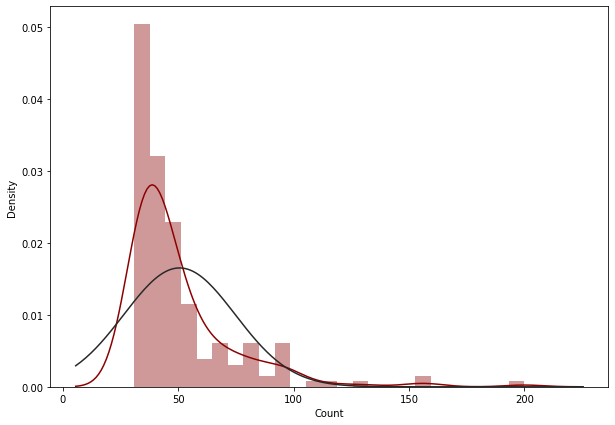

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(9, 6))
sns.distplot(data.Count, kde=True, fit=norm, color='darkred')

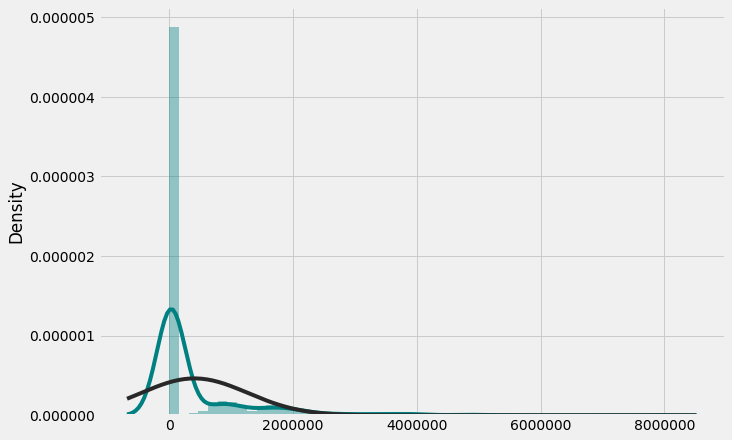

In [19]:

plt.figure(figsize=(9, 6))
sns.distplot(data.QTitTran, kde=True, fit=norm, color='teal')

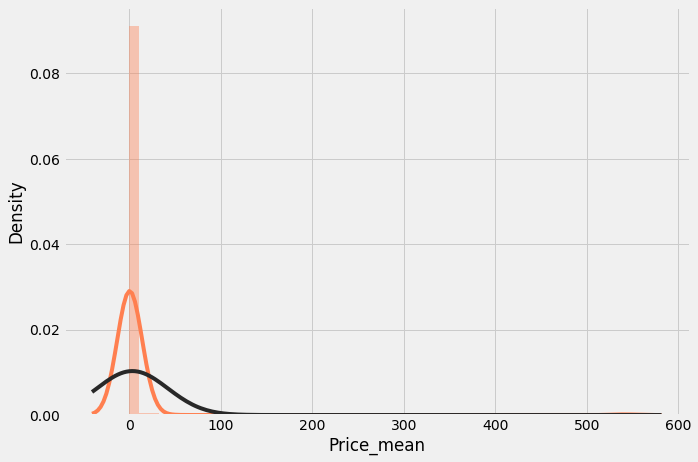

In [20]:
plt.figure(figsize=(9, 6))
sns.distplot(data.Price_mean, kde=True, fit=norm, color='coral')

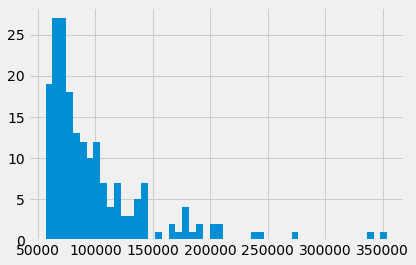

In [21]:
data.PTran_Sum.hist(bins=50)

In [22]:
data.head()

buyer   seller QTitTran                                Count PTran_Sum  \
                           sum      skew          mean    max                   
15427  34156  2252863  1272386 -0.846230  21937.689655  30000    58  135140.0   
19334  38564  1478101  1070919 -0.548201  27459.461538  59495    39   67425.0   
19399  38564  2481018   836242 -0.870208  22006.368421  30000    38   65740.0   
28508  49953   482877   900000 -0.018923  26470.588235  45000    34   64634.0   
52087  87239   383906  4002689  0.026052  49415.913580  96952    81  176904.0   

      Price_mean  
                  
15427   0.333334  
19334   0.155700  
19399   0.141816  
28508   0.162256  
52087   0.214299

In [23]:
data.columns = data.columns.map('_'.join)
data = data.reset_index(drop=True)
data = data[data.QTitTran_sum > 3800000]

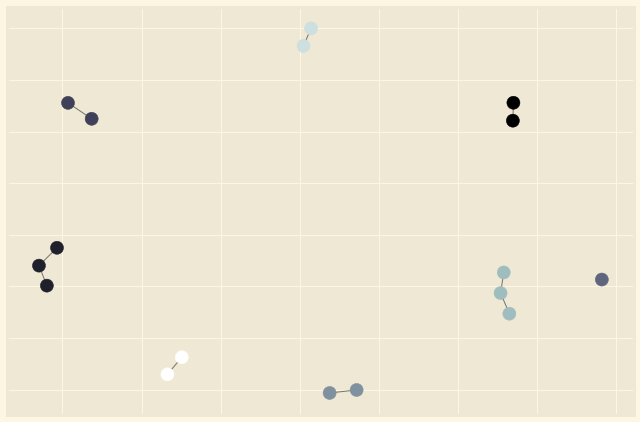

In [28]:

G=nx.from_pandas_edgelist(data, 'seller_', 'buyer_', 'QTitTran_sum' )


plt.style.use('Solarize_Light2')
plt.figure(figsize=(10, 7))
partition = community_louvain.best_partition(G); pos = nx.spring_layout(G)
cmap = cm.get_cmap('bone', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=170,
                       cmap=cmap, node_color=list(partition.values())); nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.show()

In [ ]:
from networkx.algorithms import community
from graphviz import Digraph, Graph

degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)
number_to_adjust_by = 2
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)
communities = community.greedy_modularity_communities(G)



In [33]:
data.sort_values(by='QTitTran_sum', ascending=False)

,buyer_,seller_,QTitTran_sum,QTitTran_skew,QTitTran_mean,QTitTran_max,Count_,PTran_Sum_,Price_mean_
67,1440287,1692890,7835793,-0.059920,50881.772727,98629,154,337876.0,0.183034
43,520981,2157866,5542741,-7.483315,98977.517857,100000,56,100296.0,0.018338
177,2379648,348304,4879232,0.002791,49788.081633,79232,98,201880.0,0.063256
110,1548231,1440310,4823936,-0.707709,49223.836735,60134,98,193060.0,0.043159
69,1440310,1547262,4733170,0.014792,49822.842105,99974,95,175085.0,10.500160
74,1440322,1692890,4119731,-0.012122,50240.621951,88897,82,179908.0,0.067529
4,87239,383906,4002689,0.026052,49415.913580,96952,81,176904.0,0.214299
152,2203360,2202583,3990000,-0.025811,50506.329114,90000,79,145913.0,0.101572
151,2202583,2203360,3862184,0.196261,67757.614035,100000,57,110245.0,0.033276
193,2485249,2169802,3822570,0.128042,48386.962025,98384,79,141489.0,0.083599


In [34]:
data.sort_values(by='Price_mean_', ascending=False)

,buyer_,seller_,QTitTran_sum,QTitTran_skew,QTitTran_mean,QTitTran_max,Count_,PTran_Sum_,Price_mean_
69,1440310,1547262,4733170,0.014792,49822.842105,99974,95,175085.0,10.500160
4,87239,383906,4002689,0.026052,49415.913580,96952,81,176904.0,0.214299
114,1567416,1567416,3806740,-0.126370,19033.700000,31000,200,354000.0,0.186944
67,1440287,1692890,7835793,-0.059920,50881.772727,98629,154,337876.0,0.183034
152,2203360,2202583,3990000,-0.025811,50506.329114,90000,79,145913.0,0.101572
193,2485249,2169802,3822570,0.128042,48386.962025,98384,79,141489.0,0.083599
74,1440322,1692890,4119731,-0.012122,50240.621951,88897,82,179908.0,0.067529
177,2379648,348304,4879232,0.002791,49788.081633,79232,98,201880.0,0.063256
110,1548231,1440310,4823936,-0.707709,49223.836735,60134,98,193060.0,0.043159
151,2202583,2203360,3862184,0.196261,67757.614035,100000,57,110245.0,0.033276


In [35]:
clq_spec_IRO3ZOBZ0001 = data.copy()

## **Demistify pattern**

In [36]:
data = pd.read_pickle('3mI_Clique_01.pkl')
print(data.shape)

data = data[data.InstrumentID=='IRO3ZOBZ0001']
print(data.shape)

data[(data.buyer== 1440310 )& (data.seller== 1547262)].shape

In [41]:
sets=communities

cliques_list = [list(x) for x in sets]
cliques_list

[[1692890, 1440322, 1440287],
 [1440310, 1547262, 1548231],
 [383906, 87239],
 [2157866, 520981],
 [2203360, 2202583],
 [348304, 2379648],
 [2485249, 2169802],
 [1567416]]

In [45]:
clq_spec_IRO3ZOBZ0001

,buyer_,seller_,QTitTran_sum,QTitTran_skew,QTitTran_mean,QTitTran_max,Count_,PTran_Sum_,Price_mean_
4,87239,383906,4002689,0.026052,49415.913580,96952,81,176904.0,0.214299
43,520981,2157866,5542741,-7.483315,98977.517857,100000,56,100296.0,0.018338
67,1440287,1692890,7835793,-0.059920,50881.772727,98629,154,337876.0,0.183034
69,1440310,1547262,4733170,0.014792,49822.842105,99974,95,175085.0,10.500160
74,1440322,1692890,4119731,-0.012122,50240.621951,88897,82,179908.0,0.067529
110,1548231,1440310,4823936,-0.707709,49223.836735,60134,98,193060.0,0.043159
114,1567416,1567416,3806740,-0.126370,19033.700000,31000,200,354000.0,0.186944
151,2202583,2203360,3862184,0.196261,67757.614035,100000,57,110245.0,0.033276
152,2203360,2202583,3990000,-0.025811,50506.329114,90000,79,145913.0,0.101572
177,2379648,348304,4879232,0.002791,49788.081633,79232,98,201880.0,0.063256


In [54]:
import itertools
clq_spec = pd.DataFrame(columns = ['Clq_list','buyer','seller', 'count', 'Qtsum','Qtskew', 'time_from', 'time_to'])
#clq_spec['clques'] = cliques_list
clq_rows = {}
for elmnt in cliques_list:
    clq_rows = {}
    print('Clique : ', elmnt)
    
    for a, b in itertools.combinations(elmnt, 2):
        x1 = data[(data.buyer== a )& (data.seller== b)]
        c1 = clq_spec_IRO3ZOBZ0001[(clq_spec_IRO3ZOBZ0001.buyer_== a )& (clq_spec_IRO3ZOBZ0001.seller_== b)]
        if (x1.shape[0] >0):
            #print(a, b, data[(data.buyer== a )& (data.seller== b)]['datetime'].describe())
            clq_row = {'Clq_list':elmnt,'buyer': a,'seller':b, 'count':x1.datetime.describe()['count'], 'time_from':x1.datetime.describe()['first']
                       , 'time_to':x1.datetime.describe()['last'], 'Qtsum':c1.QTitTran_sum.values[0],'Qtskew':c1.QTitTran_skew.values[0] }
            clq_spec = clq_spec.append(pd.Series(clq_row), ignore_index=True)
            
        x2 = data[(data.buyer== b )& (data.seller== a)]
        c2 = clq_spec_IRO3ZOBZ0001[(clq_spec_IRO3ZOBZ0001.buyer_== b )& (clq_spec_IRO3ZOBZ0001.seller_== a)]
        if (x2.shape[0] >0):
            #print(b, a, data[(data.buyer== b )& (data.seller== a)]['datetime'].describe())
            clq_row = {'Clq_list':elmnt,'buyer': b,'seller':a, 'count':x2.datetime.describe()['count'], 'time_from':x2.datetime.describe()['first']
                       , 'time_to':x2.datetime.describe()['last'], 'Qtsum':c2.QTitTran_sum.values[0],'Qtskew':c2.QTitTran_skew.values[0]}
            clq_spec = clq_spec.append(pd.Series(clq_row), ignore_index=True)
            
        
        

Clique :  [1692890, 1440322, 1440287]
Clique :  [1440310, 1547262, 1548231]
Clique :  [383906, 87239]
Clique :  [2157866, 520981]
Clique :  [2203360, 2202583]
Clique :  [348304, 2379648]
Clique :  [2485249, 2169802]
Clique :  [1567416]


In [56]:
clq_spec_IRO3ZOBZ0001

,buyer_,seller_,QTitTran_sum,QTitTran_skew,QTitTran_mean,QTitTran_max,Count_,PTran_Sum_,Price_mean_
4,87239,383906,4002689,0.026052,49415.913580,96952,81,176904.0,0.214299
43,520981,2157866,5542741,-7.483315,98977.517857,100000,56,100296.0,0.018338
67,1440287,1692890,7835793,-0.059920,50881.772727,98629,154,337876.0,0.183034
69,1440310,1547262,4733170,0.014792,49822.842105,99974,95,175085.0,10.500160
74,1440322,1692890,4119731,-0.012122,50240.621951,88897,82,179908.0,0.067529
110,1548231,1440310,4823936,-0.707709,49223.836735,60134,98,193060.0,0.043159
114,1567416,1567416,3806740,-0.126370,19033.700000,31000,200,354000.0,0.186944
151,2202583,2203360,3862184,0.196261,67757.614035,100000,57,110245.0,0.033276
152,2203360,2202583,3990000,-0.025811,50506.329114,90000,79,145913.0,0.101572
177,2379648,348304,4879232,0.002791,49788.081633,79232,98,201880.0,0.063256


In [55]:
clq_spec

,Clq_list,buyer,seller,count,Qtsum,Qtskew,time_from,time_to
0,"[1692890, 1440322, 1440287]",1440322,1692890,82,4119731,-0.012122,2019-09-25 11:30:19,2019-09-25 11:30:58
1,"[1692890, 1440322, 1440287]",1440287,1692890,154,7835793,-0.059920,2019-09-25 11:31:28,2019-09-25 11:32:17
2,"[1440310, 1547262, 1548231]",1440310,1547262,95,4733170,0.014792,2019-11-04 12:17:37,2019-11-04 12:17:50
3,"[1440310, 1547262, 1548231]",1548231,1440310,98,4823936,-0.707709,2019-11-03 10:33:57,2019-11-03 10:35:26
4,"[383906, 87239]",87239,383906,81,4002689,0.026052,2019-09-25 10:57:26,2019-09-25 10:59:00
5,"[2157866, 520981]",520981,2157866,56,5542741,-7.483315,2019-10-20 10:47:05,2019-10-20 10:47:05
6,"[2203360, 2202583]",2203360,2202583,79,3990000,-0.025811,2019-11-09 10:35:00,2019-11-09 10:35:01
7,"[2203360, 2202583]",2202583,2203360,57,3862184,0.196261,2019-11-02 11:43:02,2019-11-02 12:12:34
8,"[348304, 2379648]",2379648,348304,98,4879232,0.002791,2019-10-09 11:15:01,2019-10-09 11:15:01
9,"[2485249, 2169802]",2485249,2169802,79,3822570,0.128042,2019-10-20 09:46:26,2019-10-20 09:47:12


In [57]:
clq_spec.to_csv('clq_spec_IRO3ZOBZ0001.csv', index=False)